In [1]:
#General Import and Naming

File_Name = 'ANN_COSMO'
File_Dataset = "Dataset.xlsx"
File_Surfactant = 'Surfactant.xlsx'
File_Solid  = 'Solid.xlsx'
attr = ''

seed = 24

# Python â‰¥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn â‰¥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow â‰¥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


# Common imports
import numpy as np
import pandas as pd
import os

# to make this notebook's output stable across runs
np.random.seed(seed)

# To plot pretty figures
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann " + File_Name
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [2]:
#Name Selection
Desc_Config = ['Xeq(mg/L)', 'Temperature_(C)', 'pH_Alkalinity', 'Salinity_Monovalent(%wt)' ]
Desc_Target = ['Sum of Yads(mg/g)']
Desc_Solid =  ['PZC','Size(micro_meter)', 'Area(m^2/g)']

#Load dataset
df = pd.read_excel(File_Dataset)

# Select df range
Dataset_General_CMCCPP = Desc_Config + ['PZC','Area(m^2/g)' ] + ['Transitional', 'Degree_of_Branching', 'Surf_Length' ] + ['R','Critical Micelle Concentration (M)'] + Desc_Target
Dataset_COSMO_CMCCPP = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['R', 'Critical Micelle Concentration (M)'] + Desc_Target
Dataset_COSMO_CMCCPP_LV = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['MolVol','Length (Avogadro, A)','Critical Micelle Concentration (M)']+ Desc_Target
Dataset_COSMO = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + Desc_Target
Dataset_COSMO_LV = Desc_Config + ['PZC','Area(m^2/g)' ] + ['NHB-HB_Donor'] + ['Head_NHB-Hydrophobicity', 'Head_NHB-HB_Acceptor', 'Head_OT-HB_Acceptor'] + ['Tail_NHB-Hydrophobicity'] + ['MolVol','Length (Avogadro, A)']+ Desc_Target

df = df[Dataset_COSMO_LV]
Descriptor_NonX = list(df.columns.values)
Descriptor_NonX.remove('Sum of Yads(mg/g)')
Descriptor_NonX.remove('Xeq(mg/L)' )


In [3]:
#Split Dataset

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.20, random_state=seed)

test_set.head()
train_set.head()

X_test_X = test_set[['Xeq(mg/L)']].copy()
X_test_NonX = test_set[Descriptor_NonX].copy() 
X_test = pd.concat([X_test_X, X_test_NonX], axis=1).copy()
y_test = test_set[['Sum of Yads(mg/g)']].copy()

X_train_X = train_set[['Xeq(mg/L)']].copy()
X_train_NonX = train_set[Descriptor_NonX].copy() 
X_train = pd.concat([X_train_X, X_train_NonX], axis=1).copy()
y_train = train_set[['Sum of Yads(mg/g)']].copy()

In [4]:
#Subclass API Langmuir Layer

class LangmuirLayer(tf.keras.layers.Layer):
    def __init__(self, k, name=None, **kwargs):
        super(LangmuirLayer, self).__init__(name=name)
        self.k = k
        super(LangmuirLayer, self).__init__(**kwargs)
  # def build (self, inputs): no need as no constant introduced
    def get_config(self):
        config = super(LangmuirLayer, self).get_config()
        config.update({"k": self.k})
        return config
    def call(self, inputs):
        self.Ce = inputs[:, 0]
        self.Kl = inputs[:, 1]
        self.qm  = inputs[:, 2]        
        self.qm_mult_kl = tf.math.multiply(self.qm, self.Kl)
        self.kl_mult_ce = tf.math.multiply(self.Kl, self.Ce)
        self.below = tf.math.add(1.0, self.kl_mult_ce)
        self.right = tf.math.divide(self.Ce, self.below)
        self.qe = tf.math.multiply(self.qm_mult_kl, self.right)
        return tf.transpose(self.qe)

In [5]:
import shap
import numpy as np
import tensorflow as tf    
tf.compat.v1.disable_v2_behavior()

shap.initjs()

#Load Model ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
tf.keras.backend.clear_session()
tf.random.set_seed(seed)

#Load Model
#File_Name = {fill if different}
model = tf.keras.models.load_model(File_Name+attr, custom_objects={'LangmuirLayer': LangmuirLayer})



IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
Colocations handled automatically by placer.


In [6]:
# Combine X_train_X and X_train_NonX for getting median values
X_train_combined = pd.concat([X_train_X, X_train_NonX], axis=1)
med = X_train_combined.median().values.reshape((1, X_train_combined.shape[1]))

# Define wrapper function to handle the two inputs
def f(X):
    # Split the input back into X and NonX components
    X_comp = X[:, :X_train_X.shape[1]]  # First column for X
    NonX_comp = X[:, X_train_X.shape[1]:]  # Remaining columns for NonX
    return model.predict([X_comp, NonX_comp])

# Create explainer
explainer = shap.Explainer(f, med)

# Combine test data for SHAP analysis
X_test_combined = pd.concat([X_test_X, X_test_NonX], axis=1)
shap_values = explainer(X_test_combined.iloc[0:1000, :])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


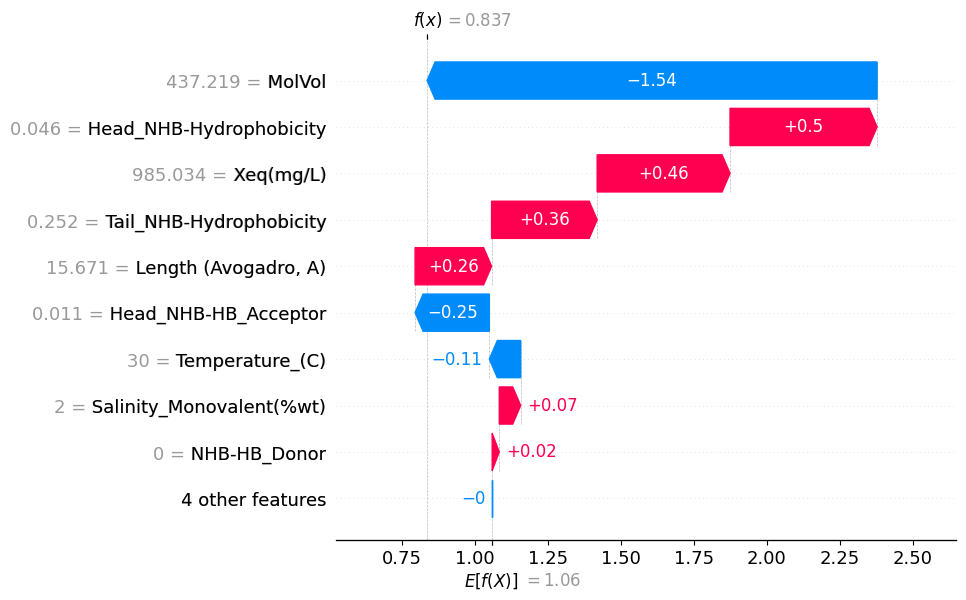

In [7]:
shap.plots.waterfall(shap_values[0])

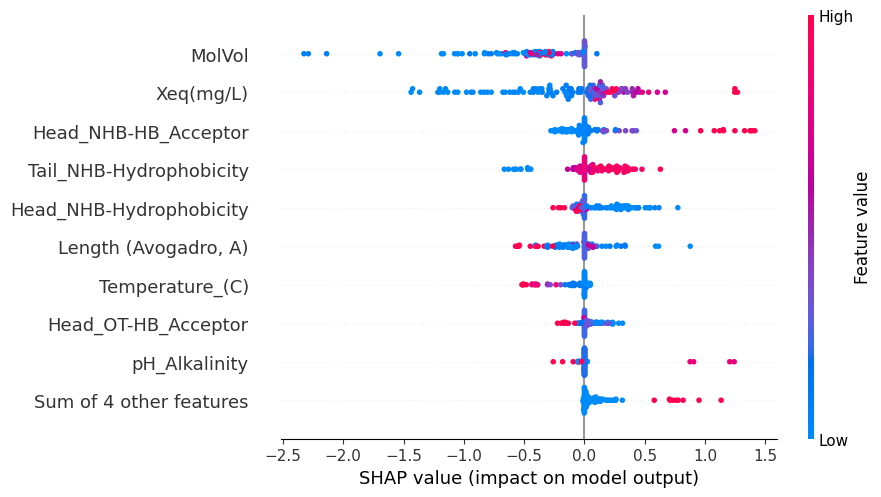

In [8]:
shap.plots.beeswarm(shap_values)

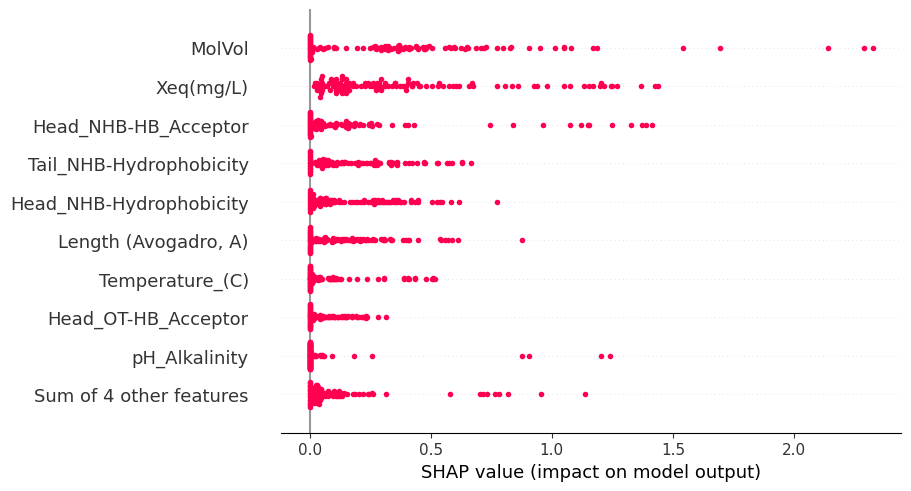

In [9]:
shap.plots.beeswarm(shap_values.abs, color="shap_red")

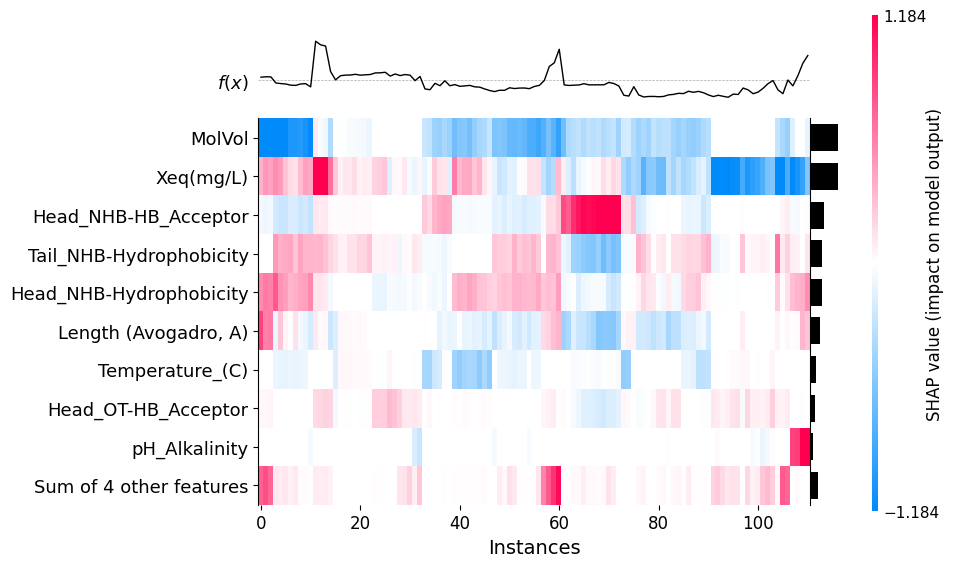

In [10]:
shap.plots.heatmap(shap_values[:1000])

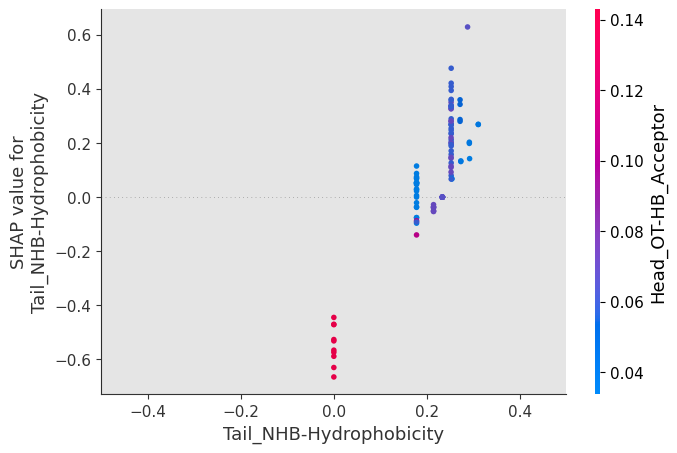

In [11]:
shap.plots.scatter(shap_values[:, "Tail_NHB-Hydrophobicity"], color=shap_values)

In [12]:
# Based on the SHAP analysis results, we can observe:

print("The SHAP analysis reveals that 'Xeq(mg/L)', 'MolVol', and 'Head_NHB-Hydrophobicity' have the strongest impact on the model's predictions. The high SHAP values for 'Xeq(mg/L)' indicate that the equilibrium concentration is a crucial factor in determining adsorption capacity. The molecular volume (MolVol) and hydrophobicity parameters also show significant influence, suggesting the importance of molecular size and surface interactions in the adsorption process.")

print("Interestingly, some parameters like 'pH_Alkalinity' and 'PZC' show relatively lower SHAP values, indicating they have less impact on the model's predictions in this specific system. The analysis also reveals complex interactions between features, particularly visible in the beeswarm and heatmap plots, where certain combinations of parameters lead to stronger effects on the predicted adsorption capacity.")

The SHAP analysis reveals that 'Xeq(mg/L)', 'MolVol', and 'Head_NHB-Hydrophobicity' have the strongest impact on the model's predictions. The high SHAP values for 'Xeq(mg/L)' indicate that the equilibrium concentration is a crucial factor in determining adsorption capacity. The molecular volume (MolVol) and hydrophobicity parameters also show significant influence, suggesting the importance of molecular size and surface interactions in the adsorption process.
Interestingly, some parameters like 'pH_Alkalinity' and 'PZC' show relatively lower SHAP values, indicating they have less impact on the model's predictions in this specific system. The analysis also reveals complex interactions between features, particularly visible in the beeswarm and heatmap plots, where certain combinations of parameters lead to stronger effects on the predicted adsorption capacity.
